# Quanvolutional Neural Network

<div>
<img src="tutorial/images/qnn.png" width="600"/>
</div>

- 2x2 Quadrat in 4-Qubit PQC
- Farbwerte sind Rotationsparameter (*pi)
- Zufällige U Layer
- Messungen für 4 Ausgangswerte

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


n_epochs = 30  # Number of optimization epochs
n_layers = 1  # Number of random layers
n_train = 500  # Size of the train dataset
n_test = 30  # Size of the test dataset
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))


@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]


def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [3]:
SAVE_PATH = "data/"  # Data saving folder
PREPROCESS = False  # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)  # Seed for NumPy random number generator
tf.random.set_seed(0)

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

if PREPROCESS:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


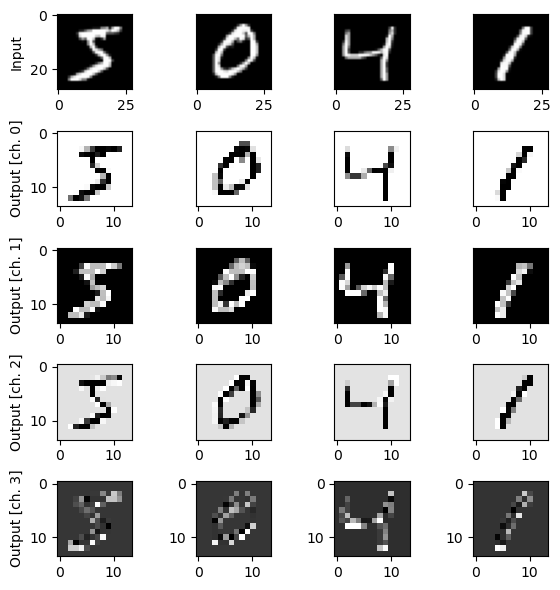

In [4]:
n_samples = 4
n_channels = 4

fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(6, 6))
for k in range(n_samples):
 axes[0, 0].set_ylabel("Input")
 if k != 0:
     axes[0, k].yaxis.set_visible(False)
 axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

 # Plot all output channels
 for c in range(n_channels):
     axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
     if k != 0:
         axes[c, k].yaxis.set_visible(False)
     axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [5]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

c_model = MyModel()

c_history = c_model.fit(
     train_images,
     train_labels,
     validation_data=(test_images, test_labels),
     batch_size=4,
     epochs=n_epochs,
     verbose=2,
)

Epoch 1/30


2023-04-06 10:43:35.419474: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


125/125 - 0s - loss: 1.7214 - accuracy: 0.4740 - val_loss: 1.1500 - val_accuracy: 0.6333 - 230ms/epoch - 2ms/step
Epoch 2/30
125/125 - 0s - loss: 0.8650 - accuracy: 0.7680 - val_loss: 0.7975 - val_accuracy: 0.7667 - 57ms/epoch - 457us/step
Epoch 3/30
125/125 - 0s - loss: 0.6147 - accuracy: 0.8340 - val_loss: 0.7308 - val_accuracy: 0.8333 - 55ms/epoch - 440us/step
Epoch 4/30
125/125 - 0s - loss: 0.4834 - accuracy: 0.8820 - val_loss: 0.6382 - val_accuracy: 0.7667 - 55ms/epoch - 438us/step
Epoch 5/30
125/125 - 0s - loss: 0.4022 - accuracy: 0.9080 - val_loss: 0.6666 - val_accuracy: 0.7667 - 56ms/epoch - 448us/step
Epoch 6/30
125/125 - 0s - loss: 0.3318 - accuracy: 0.9240 - val_loss: 0.5415 - val_accuracy: 0.8000 - 59ms/epoch - 471us/step
Epoch 7/30
125/125 - 0s - loss: 0.2833 - accuracy: 0.9520 - val_loss: 0.5054 - val_accuracy: 0.8333 - 55ms/epoch - 440us/step
Epoch 8/30
125/125 - 0s - loss: 0.2520 - accuracy: 0.9460 - val_loss: 0.4593 - val_accuracy: 0.8333 - 56ms/epoch - 447us/step
Epoc

/var/folders/7t/9rb528c94mg8mf6x8fwc0v_m0000gn/T/ipykernel_65370/322434237.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


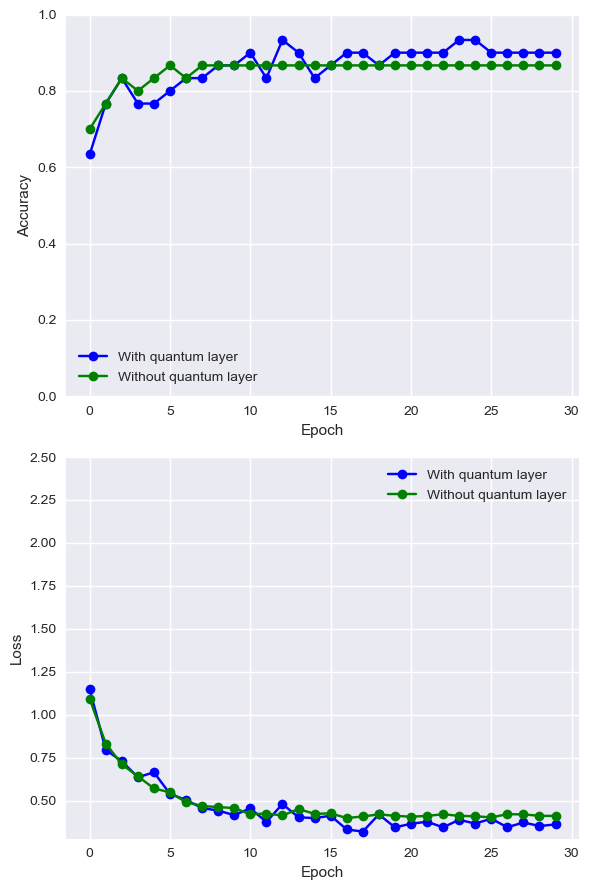

In [6]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()